In [2]:
import re
import csv
import os
import io
import pickle
import math
import random
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import pandas as pd
import hashlib as hl
import random
from dataclasses import dataclass
from datetime import datetime
from typing import Dict, List
from dataclasses import dataclass, field
from typing import Dict, TypeVar, List, Callable, Optional, Generic

sns.set_theme()

In [3]:
def cdf(series: pd.Series) -> pd.DataFrame:
    """ calculates the cumulative distribution function of the given series"""
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [4]:
lookup = """
2023-02-10T12:42:02.477732459Z - START LOOKUP KEY: QmaGp8Z7LRtz8dxC9EFFMeAs7DSg6y3To5YrkVeHGkgWAu
2023-02-10T12:42:02.477958219Z - START LOOKUP KEY: QmaGp8Z7LRtz8dxC9EFFMeAs7DSg6y3To5YrkVeHGkgWAu
2023-02-10T12:42:02.506383954Z - END LOOKUP (0.029s) KEY: QmaGp8Z7LRtz8dxC9EFFMeAs7DSg6y3To5YrkVeHGkgWAu
2023-02-10T12:46:02.306328355Z - START LOOKUP KEY: QmVS95cF7RgZJBjbeSG5CwjVE5iSDpjX8AMBqwDMtqQUt4
2023-02-10T12:46:02.312646214Z - START LOOKUP KEY: QmVS95cF7RgZJBjbeSG5CwjVE5iSDpjX8AMBqwDMtqQUt4
2023-02-10T12:46:02.652363104Z - END LOOKUP (0.346s) KEY: QmVS95cF7RgZJBjbeSG5CwjVE5iSDpjX8AMBqwDMtqQUt4
2023-02-10T12:50:02.303762088Z - START LOOKUP KEY: QmXUjuUwCLoBGu3wwAJLnQV7y7Bfnhph1YvtEh97GnyybH
2023-02-10T12:50:02.304730454Z - START LOOKUP KEY: QmXUjuUwCLoBGu3wwAJLnQV7y7Bfnhph1YvtEh97GnyybH
2023-02-10T12:50:02.560396233Z - END LOOKUP (0.257s) KEY: QmXUjuUwCLoBGu3wwAJLnQV7y7Bfnhph1YvtEh97GnyybH
2023-02-10T12:54:02.508617465Z - START LOOKUP KEY: QmZNgEMiCdBte8W9N8uWG7KuJSLPwzHWWh3WXBF8g3x6jo
2023-02-10T12:54:02.509247499Z - START LOOKUP KEY: QmZNgEMiCdBte8W9N8uWG7KuJSLPwzHWWh3WXBF8g3x6jo
2023-02-10T12:54:02.761187796Z - END LOOKUP (0.253s) KEY: QmZNgEMiCdBte8W9N8uWG7KuJSLPwzHWWh3WXBF8g3x6jo
2023-02-10T12:58:01.478489645Z - START LOOKUP KEY: QmXu9EFM2mKmF8vxTMGWSR2zTg8ogKgEvZ7isGfKgVVszX
2023-02-10T12:58:01.47970999Z - START LOOKUP KEY: QmXu9EFM2mKmF8vxTMGWSR2zTg8ogKgEvZ7isGfKgVVszX
2023-02-10T12:58:02.038729896Z - END LOOKUP (0.560s) KEY: QmXu9EFM2mKmF8vxTMGWSR2zTg8ogKgEvZ7isGfKgVVszX
2023-02-10T13:02:01.5446589Z - START LOOKUP KEY: QmQBkp8x3HQEHiBX9Chvb3Zha4tnCtR3Ez18FXn8GZceY6
2023-02-10T13:02:01.544850333Z - START LOOKUP KEY: QmQBkp8x3HQEHiBX9Chvb3Zha4tnCtR3Ez18FXn8GZceY6
2023-02-10T13:02:01.883535169Z - END LOOKUP (0.339s) KEY: QmQBkp8x3HQEHiBX9Chvb3Zha4tnCtR3Ez18FXn8GZceY6
2023-02-10T13:06:01.87721013Z - START LOOKUP KEY: QmersKVAVYJfh7tXwpwpivSz7Zuc3dGw2E3dUKqHAjdpGn
2023-02-10T13:06:01.877894106Z - START LOOKUP KEY: QmersKVAVYJfh7tXwpwpivSz7Zuc3dGw2E3dUKqHAjdpGn
2023-02-10T13:06:02.096506166Z - END LOOKUP (0.219s) KEY: QmersKVAVYJfh7tXwpwpivSz7Zuc3dGw2E3dUKqHAjdpGn
2023-02-10T13:10:02.252773893Z - START LOOKUP KEY: QmXu5rQiYi8tckzxpbb1WggWcR9GT9jwN3xtAnm5ZcHbH8
2023-02-10T13:10:02.256949331Z - START LOOKUP KEY: QmXu5rQiYi8tckzxpbb1WggWcR9GT9jwN3xtAnm5ZcHbH8
2023-02-10T13:10:02.767279627Z - END LOOKUP (0.515s) KEY: QmXu5rQiYi8tckzxpbb1WggWcR9GT9jwN3xtAnm5ZcHbH8
2023-02-10T13:14:02.309189956Z - START LOOKUP KEY: QmShHU43J1nkBCL63Pjr4iyYRKncK1DFjqAUbZwFXSmCg7
2023-02-10T13:14:02.30982241Z - START LOOKUP KEY: QmShHU43J1nkBCL63Pjr4iyYRKncK1DFjqAUbZwFXSmCg7
2023-02-10T13:14:02.705517285Z - END LOOKUP (0.396s) KEY: QmShHU43J1nkBCL63Pjr4iyYRKncK1DFjqAUbZwFXSmCg7
2023-02-10T13:18:02.383240158Z - START LOOKUP KEY: QmbfBMfBsM5PjZoUZnKdKskxXMubHPtbHYWSxaqaekU1VT
2023-02-10T13:18:02.383565475Z - START LOOKUP KEY: QmbfBMfBsM5PjZoUZnKdKskxXMubHPtbHYWSxaqaekU1VT
2023-02-10T13:18:02.514996946Z - END LOOKUP (0.132s) KEY: QmbfBMfBsM5PjZoUZnKdKskxXMubHPtbHYWSxaqaekU1VT
2023-02-10T13:22:02.43822561Z - START LOOKUP KEY: Qmdhi3HxeePh5skpRdQgb6MpLvsTrAfiEU1k3pWVyS7P6c
2023-02-10T13:22:02.438427406Z - START LOOKUP KEY: Qmdhi3HxeePh5skpRdQgb6MpLvsTrAfiEU1k3pWVyS7P6c
2023-02-10T13:22:02.815639323Z - END LOOKUP (0.377s) KEY: Qmdhi3HxeePh5skpRdQgb6MpLvsTrAfiEU1k3pWVyS7P6c
2023-02-10T13:26:02.204908402Z - START LOOKUP KEY: QmNuDzmr5HJvyWQzjYt7bKYoCZvs3ueuLQUNo9fbzpEhCj
2023-02-10T13:26:02.205863224Z - START LOOKUP KEY: QmNuDzmr5HJvyWQzjYt7bKYoCZvs3ueuLQUNo9fbzpEhCj
2023-02-10T13:26:02.482986705Z - END LOOKUP (0.278s) KEY: QmNuDzmr5HJvyWQzjYt7bKYoCZvs3ueuLQUNo9fbzpEhCj
2023-02-10T13:30:02.628811534Z - START LOOKUP KEY: QmTSJb6sE6Kdjwc4CjL2QwZXzGaZXRoAjELgidSDPnHS1D
2023-02-10T13:30:02.630162745Z - START LOOKUP KEY: QmTSJb6sE6Kdjwc4CjL2QwZXzGaZXRoAjELgidSDPnHS1D
2023-02-10T13:30:03.259450009Z - END LOOKUP (0.631s) KEY: QmTSJb6sE6Kdjwc4CjL2QwZXzGaZXRoAjELgidSDPnHS1D
2023-02-10T13:34:02.113775534Z - START LOOKUP KEY: QmNuZkoa15BsqMgBhhzDtkKybCCzKPQPLSB5HFxJoGr1vh
2023-02-10T13:34:02.114077321Z - START LOOKUP KEY: QmNuZkoa15BsqMgBhhzDtkKybCCzKPQPLSB5HFxJoGr1vh
2023-02-10T13:34:02.259252993Z - END LOOKUP (0.145s) KEY: QmNuZkoa15BsqMgBhhzDtkKybCCzKPQPLSB5HFxJoGr1vh
2023-02-10T13:38:02.029021842Z - START LOOKUP KEY: QmVREXzUgRugddFBZvSLmfrvyaEzp9mBiMsiVTd7buPEek
2023-02-10T13:38:02.029208527Z - START LOOKUP KEY: QmVREXzUgRugddFBZvSLmfrvyaEzp9mBiMsiVTd7buPEek
2023-02-10T13:38:02.257645435Z - END LOOKUP (0.229s) KEY: QmVREXzUgRugddFBZvSLmfrvyaEzp9mBiMsiVTd7buPEek
2023-02-10T13:42:02.419014689Z - START LOOKUP KEY: QmdijYkYkxT4jNn3YbztnLKseFLTtQ9D9fnPJ2FbJJkySu
2023-02-10T13:42:02.419419061Z - START LOOKUP KEY: QmdijYkYkxT4jNn3YbztnLKseFLTtQ9D9fnPJ2FbJJkySu
2023-02-10T13:42:02.688630569Z - END LOOKUP (0.270s) KEY: QmdijYkYkxT4jNn3YbztnLKseFLTtQ9D9fnPJ2FbJJkySu
2023-02-10T13:46:01.71237459Z - START LOOKUP KEY: QmeRFnK3bRzE8jz9EaosvszHr3YSPX8ARMFnsxmgfLxanu
2023-02-10T13:46:01.712765853Z - START LOOKUP KEY: QmeRFnK3bRzE8jz9EaosvszHr3YSPX8ARMFnsxmgfLxanu
2023-02-10T13:46:02.3465617Z - END LOOKUP (0.634s) KEY: QmeRFnK3bRzE8jz9EaosvszHr3YSPX8ARMFnsxmgfLxanu
2023-02-10T13:50:02.118317065Z - START LOOKUP KEY: Qmam27uM1ahtLUwAbkRUM6oXrQeuWqLcfSJTN8WGd22GRi
2023-02-10T13:50:02.118461154Z - START LOOKUP KEY: Qmam27uM1ahtLUwAbkRUM6oXrQeuWqLcfSJTN8WGd22GRi
2023-02-10T13:50:02.565812998Z - END LOOKUP (0.448s) KEY: Qmam27uM1ahtLUwAbkRUM6oXrQeuWqLcfSJTN8WGd22GRi
2023-02-10T13:54:01.802670275Z - START LOOKUP KEY: QmNVtaanXNrRPxNZH5Nf3EMBFQved6XBFEWhNSo22W6QRN
2023-02-10T13:54:01.80730112Z - START LOOKUP KEY: QmNVtaanXNrRPxNZH5Nf3EMBFQved6XBFEWhNSo22W6QRN
2023-02-10T13:54:02.202999524Z - END LOOKUP (0.400s) KEY: QmNVtaanXNrRPxNZH5Nf3EMBFQved6XBFEWhNSo22W6QRN
2023-02-10T13:58:02.04258405Z - START LOOKUP KEY: Qmcp36kYyhezCP3th1fUbcectiDWRCJXmxvvs9du4jP1yD
2023-02-10T13:58:02.042809177Z - START LOOKUP KEY: Qmcp36kYyhezCP3th1fUbcectiDWRCJXmxvvs9du4jP1yD
2023-02-10T13:58:02.220278963Z - END LOOKUP (0.178s) KEY: Qmcp36kYyhezCP3th1fUbcectiDWRCJXmxvvs9du4jP1yD
2023-02-10T14:02:02.007647157Z - START LOOKUP KEY: QmZn1gMyQjDgQ7xUEEz4VAYX8EYWPETWGhxaybFWsrJHs9
2023-02-10T14:02:02.009632449Z - START LOOKUP KEY: QmZn1gMyQjDgQ7xUEEz4VAYX8EYWPETWGhxaybFWsrJHs9
2023-02-10T14:02:02.129494501Z - END LOOKUP (0.122s) KEY: QmZn1gMyQjDgQ7xUEEz4VAYX8EYWPETWGhxaybFWsrJHs9
2023-02-10T14:06:02.307927907Z - START LOOKUP KEY: QmPq3SMmtXV5GkXoZ18gbrmbjzb4BMjdr8wjZ9tkRHbrPs
2023-02-10T14:06:02.309470694Z - START LOOKUP KEY: QmPq3SMmtXV5GkXoZ18gbrmbjzb4BMjdr8wjZ9tkRHbrPs
2023-02-10T14:06:02.998992358Z - END LOOKUP (0.690s) KEY: QmPq3SMmtXV5GkXoZ18gbrmbjzb4BMjdr8wjZ9tkRHbrPs
2023-02-10T14:10:02.494101587Z - START LOOKUP KEY: QmPHWyPbELAA2EH81jJPjWDJbEfxmdDpJ6kuE1XcMDb3v9
2023-02-10T14:10:02.498054287Z - START LOOKUP KEY: QmPHWyPbELAA2EH81jJPjWDJbEfxmdDpJ6kuE1XcMDb3v9
2023-02-10T14:10:02.94849148Z - END LOOKUP (0.454s) KEY: QmPHWyPbELAA2EH81jJPjWDJbEfxmdDpJ6kuE1XcMDb3v9
2023-02-10T14:14:02.238272547Z - START LOOKUP KEY: QmTtq1FszTP1RrkUy4RbK5B1dvQeacp2bScEEzDatthDk3
2023-02-10T14:14:02.238272556Z - START LOOKUP KEY: QmTtq1FszTP1RrkUy4RbK5B1dvQeacp2bScEEzDatthDk3
2023-02-10T14:14:02.667949541Z - END LOOKUP (0.430s) KEY: QmTtq1FszTP1RrkUy4RbK5B1dvQeacp2bScEEzDatthDk3
2023-02-10T14:18:01.782257944Z - START LOOKUP KEY: QmXZsCrCLX2joAwjys9DNoE8Few3cFV36JJjWqRYEQtSwQ
2023-02-10T14:18:01.785963323Z - START LOOKUP KEY: QmXZsCrCLX2joAwjys9DNoE8Few3cFV36JJjWqRYEQtSwQ
2023-02-10T14:18:02.010076301Z - END LOOKUP (0.228s) KEY: QmXZsCrCLX2joAwjys9DNoE8Few3cFV36JJjWqRYEQtSwQ
2023-02-10T14:22:02.280809539Z - START LOOKUP KEY: QmPenYTZcDWvbDABWTfVYX4eUbAZoRzDhuFh2nfhKetDMU
2023-02-10T14:22:02.281715671Z - START LOOKUP KEY: QmPenYTZcDWvbDABWTfVYX4eUbAZoRzDhuFh2nfhKetDMU
2023-02-10T14:22:02.387526783Z - END LOOKUP (0.107s) KEY: QmPenYTZcDWvbDABWTfVYX4eUbAZoRzDhuFh2nfhKetDMU
2023-02-10T14:26:02.35640029Z - START LOOKUP KEY: QmYf8DX5MonuDLa4wySsWjVQvQqkKiwS2mb1Tc7in1fQrH
2023-02-10T14:26:02.356393591Z - START LOOKUP KEY: QmYf8DX5MonuDLa4wySsWjVQvQqkKiwS2mb1Tc7in1fQrH
2023-02-10T14:26:02.535177664Z - END LOOKUP (0.179s) KEY: QmYf8DX5MonuDLa4wySsWjVQvQqkKiwS2mb1Tc7in1fQrH
2023-02-10T14:30:02.280135986Z - START LOOKUP KEY: QmbhiFFspqvkXfCbPtBKqATJeZk9tyi6MqgsQG3Njwb7pT
2023-02-10T14:30:02.280136672Z - START LOOKUP KEY: QmbhiFFspqvkXfCbPtBKqATJeZk9tyi6MqgsQG3Njwb7pT
2023-02-10T14:30:02.629882659Z - END LOOKUP (0.350s) KEY: QmbhiFFspqvkXfCbPtBKqATJeZk9tyi6MqgsQG3Njwb7pT
2023-02-10T14:34:02.037872501Z - START LOOKUP KEY: QmNeX3ha2yrz8DVq5ZMTkT9qT3THHTQ4hyaHrAcVzky6ud
2023-02-10T14:34:02.038748302Z - START LOOKUP KEY: QmNeX3ha2yrz8DVq5ZMTkT9qT3THHTQ4hyaHrAcVzky6ud
2023-02-10T14:34:02.442810648Z - END LOOKUP (0.405s) KEY: QmNeX3ha2yrz8DVq5ZMTkT9qT3THHTQ4hyaHrAcVzky6ud
2023-02-10T14:38:02.069917506Z - START LOOKUP KEY: QmNSGWWXoHF66nVmWbpUwUKkaqzEgMksQESadEi17qkqxB
2023-02-10T14:38:02.070103008Z - START LOOKUP KEY: QmNSGWWXoHF66nVmWbpUwUKkaqzEgMksQESadEi17qkqxB
2023-02-10T14:38:02.200594142Z - END LOOKUP (0.131s) KEY: QmNSGWWXoHF66nVmWbpUwUKkaqzEgMksQESadEi17qkqxB
2023-02-10T14:42:01.701135322Z - START LOOKUP KEY: QmeC7QssSQjRLR1Jsz6fhRwhfoTMyEKMe6z5aCZ7G5gzWR
2023-02-10T14:42:01.70160559Z - START LOOKUP KEY: QmeC7QssSQjRLR1Jsz6fhRwhfoTMyEKMe6z5aCZ7G5gzWR
2023-02-10T14:42:01.917870332Z - END LOOKUP (0.218s) KEY: QmeC7QssSQjRLR1Jsz6fhRwhfoTMyEKMe6z5aCZ7G5gzWR
2023-02-10T14:46:02.554211153Z - START LOOKUP KEY: QmUCY9k15QWVdAZfm76aFcfgKwqLKhQM3U5KD4kwSMghm1
2023-02-10T14:46:02.555719429Z - START LOOKUP KEY: QmUCY9k15QWVdAZfm76aFcfgKwqLKhQM3U5KD4kwSMghm1
2023-02-10T14:46:03.309260799Z - END LOOKUP (0.755s) KEY: QmUCY9k15QWVdAZfm76aFcfgKwqLKhQM3U5KD4kwSMghm1
2023-02-10T14:46:03.310728458Z - END LOOKUP (0.757s) KEY: QmUCY9k15QWVdAZfm76aFcfgKwqLKhQM3U5KD4kwSMghm1
2023-02-10T14:50:02.425569851Z - START LOOKUP KEY: QmTBP9QFPXP8cF5YWwQjF173Z562F3NqhZf71Lvtehe1Zy
2023-02-10T14:50:02.43704534Z - START LOOKUP KEY: QmTBP9QFPXP8cF5YWwQjF173Z562F3NqhZf71Lvtehe1Zy
2023-02-10T14:50:02.656958786Z - END LOOKUP (0.231s) KEY: QmTBP9QFPXP8cF5YWwQjF173Z562F3NqhZf71Lvtehe1Zy
2023-02-10T14:54:02.071081829Z - START LOOKUP KEY: Qmb9xTJ5agXJfgYjqwzVxUCpNkomkeFb5MwLrj3bKUjDvo
2023-02-10T14:54:02.071290175Z - START LOOKUP KEY: Qmb9xTJ5agXJfgYjqwzVxUCpNkomkeFb5MwLrj3bKUjDvo
2023-02-10T14:54:02.608912447Z - END LOOKUP (0.538s) KEY: Qmb9xTJ5agXJfgYjqwzVxUCpNkomkeFb5MwLrj3bKUjDvo
2023-02-10T14:58:02.548813256Z - START LOOKUP KEY: QmXJDEnyN2W8V916HSQqdQ42hwNULM7gLGBR8F9wKAb3yX
2023-02-10T14:58:02.549384768Z - START LOOKUP KEY: QmXJDEnyN2W8V916HSQqdQ42hwNULM7gLGBR8F9wKAb3yX
2023-02-10T14:58:03.814240208Z - END LOOKUP (1.265s) KEY: QmXJDEnyN2W8V916HSQqdQ42hwNULM7gLGBR8F9wKAb3yX
2023-02-10T15:02:02.565775569Z - START LOOKUP KEY: QmNcBKXXUYhkKmbdpGVnyapymHvVmqfJMthKKXWuELzpf4
2023-02-10T15:02:02.56920003Z - START LOOKUP KEY: QmNcBKXXUYhkKmbdpGVnyapymHvVmqfJMthKKXWuELzpf4
2023-02-10T15:02:02.97311389Z - END LOOKUP (0.407s) KEY: QmNcBKXXUYhkKmbdpGVnyapymHvVmqfJMthKKXWuELzpf4
2023-02-10T15:06:01.330364172Z - START LOOKUP KEY: QmS38VAkUpPmq7rRHwEuhgXACb6YTvc9AMtREBCRygJTnD
2023-02-10T15:06:01.33129799Z - START LOOKUP KEY: QmS38VAkUpPmq7rRHwEuhgXACb6YTvc9AMtREBCRygJTnD
2023-02-10T15:06:02.18075109Z - END LOOKUP (0.850s) KEY: QmS38VAkUpPmq7rRHwEuhgXACb6YTvc9AMtREBCRygJTnD
2023-02-10T15:10:02.24820957Z - START LOOKUP KEY: Qma1vBuSEQMNF76skHrajgQmMmv8JCT8gGYEcDDkRsUXMc
2023-02-10T15:10:02.264784934Z - START LOOKUP KEY: Qma1vBuSEQMNF76skHrajgQmMmv8JCT8gGYEcDDkRsUXMc
2023-02-10T15:10:02.361189179Z - END LOOKUP (0.113s) KEY: Qma1vBuSEQMNF76skHrajgQmMmv8JCT8gGYEcDDkRsUXMc
2023-02-10T15:14:02.392983118Z - START LOOKUP KEY: QmSaitZhZ9AkVVPdBYthnbVCtSNF24Hx5Pur86yNrD3KR5
2023-02-10T15:14:02.393852283Z - START LOOKUP KEY: QmSaitZhZ9AkVVPdBYthnbVCtSNF24Hx5Pur86yNrD3KR5
2023-02-10T15:14:02.481488654Z - END LOOKUP (0.089s) KEY: QmSaitZhZ9AkVVPdBYthnbVCtSNF24Hx5Pur86yNrD3KR5
"""

lookups = {}

for line in lookup.split("\n"):
    match = re.search(r"(.*) - END LOOKUP \((.*)\).* KEY: (.*)", line)
    if match is None:
        continue
    lookups[match.group(3)] = float(match.group(2)[:-1])

In [5]:
cli = """
2023-02-10 12:42:02.519663814+00:00,0.170,ok,QmaGp8Z7LRtz8dxC9EFFMeAs7DSg6y3To5YrkVeHGkgWAu
2023-02-10 12:46:02.666128019+00:00,0.409,ok,QmVS95cF7RgZJBjbeSG5CwjVE5iSDpjX8AMBqwDMtqQUt4
2023-02-10 12:50:02.573293706+00:00,0.333,ok,QmXUjuUwCLoBGu3wwAJLnQV7y7Bfnhph1YvtEh97GnyybH
2023-02-10 12:54:02.809426659+00:00,0.466,ok,QmZNgEMiCdBte8W9N8uWG7KuJSLPwzHWWh3WXBF8g3x6jo
2023-02-10 12:58:02.052188433+00:00,0.620,ok,QmXu9EFM2mKmF8vxTMGWSR2zTg8ogKgEvZ7isGfKgVVszX
2023-02-10 13:02:01.895827089+00:00,0.445,ok,QmQBkp8x3HQEHiBX9Chvb3Zha4tnCtR3Ez18FXn8GZceY6
2023-02-10 13:06:02.121920310+00:00,0.311,ok,QmersKVAVYJfh7tXwpwpivSz7Zuc3dGw2E3dUKqHAjdpGn
2023-02-10 13:10:02.780378942+00:00,0.573,ok,QmXu5rQiYi8tckzxpbb1WggWcR9GT9jwN3xtAnm5ZcHbH8
2023-02-10 13:14:02.718521445+00:00,0.477,ok,QmShHU43J1nkBCL63Pjr4iyYRKncK1DFjqAUbZwFXSmCg7
2023-02-10 13:18:02.531061658+00:00,0.211,ok,QmbfBMfBsM5PjZoUZnKdKskxXMubHPtbHYWSxaqaekU1VT
2023-02-10 13:22:02.827792199+00:00,0.501,ok,Qmdhi3HxeePh5skpRdQgb6MpLvsTrAfiEU1k3pWVyS7P6c
2023-02-10 13:26:02.496234027+00:00,0.389,ok,QmNuDzmr5HJvyWQzjYt7bKYoCZvs3ueuLQUNo9fbzpEhCj
2023-02-10 13:30:03.282035571+00:00,0.762,ok,QmTSJb6sE6Kdjwc4CjL2QwZXzGaZXRoAjELgidSDPnHS1D
2023-02-10 13:34:02.281315727+00:00,0.324,ok,QmNuZkoa15BsqMgBhhzDtkKybCCzKPQPLSB5HFxJoGr1vh
2023-02-10 13:38:02.278994430+00:00,0.295,ok,QmVREXzUgRugddFBZvSLmfrvyaEzp9mBiMsiVTd7buPEek
2023-02-10 13:42:02.700172335+00:00,0.395,ok,QmdijYkYkxT4jNn3YbztnLKseFLTtQ9D9fnPJ2FbJJkySu
2023-02-10 13:46:02.369490228+00:00,0.730,ok,QmeRFnK3bRzE8jz9EaosvszHr3YSPX8ARMFnsxmgfLxanu
2023-02-10 13:50:02.581412852+00:00,0.506,ok,Qmam27uM1ahtLUwAbkRUM6oXrQeuWqLcfSJTN8WGd22GRi
2023-02-10 13:54:02.218253906+00:00,0.521,ok,QmNVtaanXNrRPxNZH5Nf3EMBFQved6XBFEWhNSo22W6QRN
2023-02-10 13:58:02.248068949+00:00,0.246,ok,Qmcp36kYyhezCP3th1fUbcectiDWRCJXmxvvs9du4jP1yD
2023-02-10 14:02:02.141679963+00:00,0.226,ok,QmZn1gMyQjDgQ7xUEEz4VAYX8EYWPETWGhxaybFWsrJHs9
2023-02-10 14:06:03.014375823+00:00,0.807,ok,QmPq3SMmtXV5GkXoZ18gbrmbjzb4BMjdr8wjZ9tkRHbrPs
2023-02-10 14:10:02.978233374+00:00,0.546,ok,QmPHWyPbELAA2EH81jJPjWDJbEfxmdDpJ6kuE1XcMDb3v9
2023-02-10 14:14:02.731288477+00:00,0.676,ok,QmTtq1FszTP1RrkUy4RbK5B1dvQeacp2bScEEzDatthDk3
2023-02-10 14:18:02.041943526+00:00,0.385,ok,QmXZsCrCLX2joAwjys9DNoE8Few3cFV36JJjWqRYEQtSwQ
2023-02-10 14:22:02.403636396+00:00,0.197,ok,QmPenYTZcDWvbDABWTfVYX4eUbAZoRzDhuFh2nfhKetDMU
2023-02-10 14:26:02.550254908+00:00,0.420,ok,QmYf8DX5MonuDLa4wySsWjVQvQqkKiwS2mb1Tc7in1fQrH
2023-02-10 14:30:02.649865612+00:00,0.432,ok,QmbhiFFspqvkXfCbPtBKqATJeZk9tyi6MqgsQG3Njwb7pT
2023-02-10 14:34:02.455538790+00:00,0.503,ok,QmNeX3ha2yrz8DVq5ZMTkT9qT3THHTQ4hyaHrAcVzky6ud
2023-02-10 14:38:02.219576431+00:00,0.207,ok,QmNSGWWXoHF66nVmWbpUwUKkaqzEgMksQESadEi17qkqxB
2023-02-10 14:42:01.944382490+00:00,0.390,ok,QmeC7QssSQjRLR1Jsz6fhRwhfoTMyEKMe6z5aCZ7G5gzWR
2023-02-10 14:46:03.349793109+00:00,0.864,ok,QmUCY9k15QWVdAZfm76aFcfgKwqLKhQM3U5KD4kwSMghm1
2023-02-10 14:50:02.669264829+00:00,0.375,ok,QmTBP9QFPXP8cF5YWwQjF173Z562F3NqhZf71Lvtehe1Zy
2023-02-10 14:54:02.625278685+00:00,0.610,ok,Qmb9xTJ5agXJfgYjqwzVxUCpNkomkeFb5MwLrj3bKUjDvo
2023-02-10 14:50:02.669264829+00:00,0.375,ok,QmTBP9QFPXP8cF5YWwQjF173Z562F3NqhZf71Lvtehe1Zy
2023-02-10 14:54:02.625278685+00:00,0.610,ok,Qmb9xTJ5agXJfgYjqwzVxUCpNkomkeFb5MwLrj3bKUjDvo
2023-02-10 14:58:03.825008845+00:00,1.373,ok,QmXJDEnyN2W8V916HSQqdQ42hwNULM7gLGBR8F9wKAb3yX
2023-02-10 15:02:03.012653380+00:00,0.529,ok,QmNcBKXXUYhkKmbdpGVnyapymHvVmqfJMthKKXWuELzpf4
2023-02-10 15:06:02.195014325+00:00,0.902,ok,QmS38VAkUpPmq7rRHwEuhgXACb6YTvc9AMtREBCRygJTnD
2023-02-10 15:10:02.379754615+00:00,0.194,ok,Qma1vBuSEQMNF76skHrajgQmMmv8JCT8gGYEcDDkRsUXMc
2023-02-10 15:14:02.496596018+00:00,0.224,ok,QmSaitZhZ9AkVVPdBYthnbVCtSNF24Hx5Pur86yNrD3KR5
"""
cs = {}
for c in cli.split("\n"):
    s = c.split(",")
    if len(s) < 2:
        continue
    cs[s[3]] = float(s[1])

In [6]:
diffs = []
for cid in cs.keys():
    if cid not in lookups:
        print(cid)
        continue
    diffs += [cs[cid] - lookups[cid]]

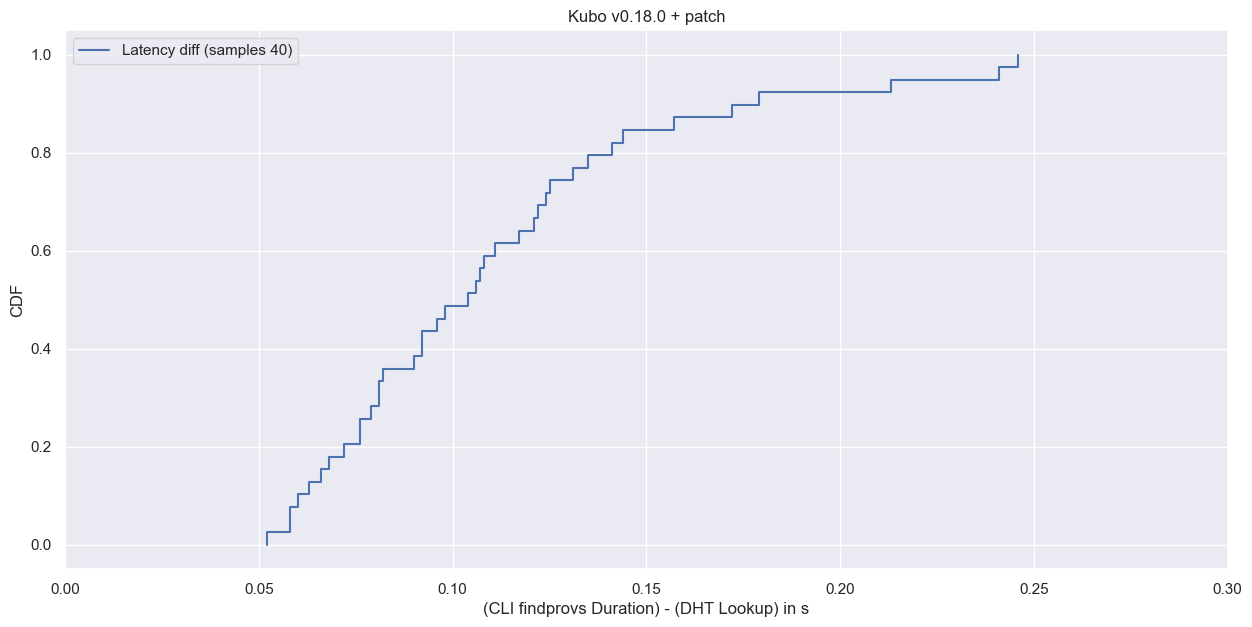

In [8]:
fig, ax = plt.subplots(figsize=[15, 7])

dat = cdf(pd.Series(diffs, name="durations"))
ax.step(dat["durations"], dat["cdf"], label=f"Latency diff (samples {len(dat)})")
ax.set_xlim(0, 0.3)
ax.set_xlabel("(CLI findprovs Duration) - (DHT Lookup) in s")
ax.set_ylabel("CDF")
ax.set_title("Kubo v0.18.0 + patch")
ax.legend()